In [104]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import math
from UnifiedMomentumModel.Momentum import UnifiedMomentum

In [105]:
def analytical_a(CT):
    # note that CT is actually CT'
    return CT / (4 + CT)

def a_to_Cp(a, alg = "classical"):
    return 4 * a * (1 - a)**2

def johlas(cp, sa, pa):
    v = 0
    if sa != 0:  # surging
        v = sa  # why doesn't this depend on f?
    else:  # pitching
        v = 0#np.sin(np.deg2rad(pa))
    x_disp = (1 + (3 * (v**2)) / 2)
    theta_disp = np.mean([np.cos(np.deg2rad(pa) * np.sin(x))**3 for x in np.linspace(0, 2 * np.pi, 250)])
    return cp * x_disp * theta_disp

In [121]:
def natural_sort(l): 
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)', key)]
    return sorted(l, key=alphanum_key)

df = pd.read_csv("/Users/sky/src/HowlandLab/data/expanded_moving_analysis.csv")
df = df.dropna()

In [123]:
df

,Unnamed: 0,marker,nx,ny,filter,filterFactor,useCorrection,CT_prime,turbulence,surge_freq,...,variance_Cp,std_CT,std_an,std_Cp,skewness_CT,skewness_an,skewness_Cp,kurtosis_CT,kurtosis_an,kurtosis_Cp
0,0,o,64.0,32.0,0.589831,1.000,True,1.0,False,0.0,...,3.197882e-12,1.472572e-06,9.108791e-07,1.785475e-06,3.114115,-3.114112,3.114117,9.390863,9.390842,9.390885
1,1,o,128.0,64.0,0.294915,1.000,True,1.0,False,0.0,...,7.861220e-12,2.282117e-06,1.394218e-06,2.801602e-06,-0.121881,0.121894,-0.121868,3.161778,3.161781,3.161775
2,2,o,256.0,128.0,0.147458,1.000,True,1.0,False,0.0,...,6.806981e-13,6.849901e-07,4.266991e-07,8.247230e-07,-0.367102,0.367104,-0.367100,0.398371,0.398372,0.398369
3,3,o,64.0,32.0,0.080000,0.136,True,1.0,False,0.0,...,1.359172e-11,2.926576e-06,1.745104e-06,3.680949e-06,2.864592,-2.864584,2.864601,8.871645,8.871581,8.871710
4,4,o,128.0,64.0,0.080000,0.271,True,1.0,False,0.0,...,3.867314e-10,1.578250e-05,9.507068e-06,1.965017e-05,-0.071558,0.071595,-0.071521,0.155124,0.155125,0.155123
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
158,158,^,256.0,128.0,0.221187,1.500,True,4.0,False,1.0,...,1.199611e-07,4.466869e-04,1.080326e-04,3.463005e-04,1.243653,-1.242602,1.244704,2.899755,2.895684,2.903831
159,159,^,256.0,128.0,0.221187,1.500,True,4.0,False,1.0,...,3.510545e-06,2.410927e-03,5.817676e-04,1.873355e-03,-0.000955,0.002057,0.000147,-1.345821,-1.345799,-1.345840
163,163,^,256.0,128.0,0.221187,1.500,True,4.0,False,0.1,...,7.093232e-05,1.078100e-02,2.588040e-03,8.420830e-03,0.011516,-0.007788,0.015243,-1.499835,-1.499924,-1.499718
164,164,^,256.0,128.0,0.221187,1.500,True,4.0,False,0.5,...,2.330860e-04,1.944916e-02,4.646580e-03,1.526479e-02,0.012566,-0.005905,0.019226,-1.499853,-1.499977,-1.499643


In [ ]:
df = df.dropna()
df['Movement'] = df.apply(lambda row: ("Stationary" if row.marker == "o" else ("Surging" if row.marker == "s" else "Pitching")), axis = 1)
df = df[df.nx == 256]  # only keep 256 x 128 x 128 simulations
df = df[df.filterFactor == 1.5]
df = df[df.useCorrection]

cols_to_keep = ["Movement", "nx", "filterFactor", "filterFactor", "useCorrection", "turbulence", "CT_prime", "surge_freq", "surge_amplitude", "pitch_amplitude"]
df = df.drop_duplicates(subset = cols_to_keep, keep = 'last')

In [109]:
max_motion_df = df[df["surge_freq"] == 1]
max_motion_df = max_motion_df[(max_motion_df["surge_amplitude"] == 0.5) | (max_motion_df["pitch_amplitude"] == 5)]

In [110]:
def fix_legend(ax, title = ""):
    leg = ax.legend(title = title, title_fontsize ='12')
    # leg.set_title("")
    plt.setp(leg.get_texts(), fontsize='12')
    bb = leg.get_bbox_to_anchor().transformed(ax.transAxes.inverted())
    xOffset = 0.35
    bb.x0 += xOffset
    bb.x1 += xOffset
    leg = leg.set_bbox_to_anchor(bb, transform = ax.transAxes)

In [111]:
ctp_list = np.linspace(0.01, 10, num = 100)
# johlas_based on classical
classical_cp = [a_to_Cp(analytical_a(ctp)) for ctp in ctp_list]
johlas_pitch_classical = [johlas(cp, 0.0, 5.0) for cp in classical_cp]
johlas_surge_classical = [johlas(cp, 0.5, 0.0) for cp in classical_cp]
# johlas based on UMM
model = UnifiedMomentum()
umm_cp = model(Ctprime = ctp_list, yaw = 0.0).Cp
johlas_pitch_umm = [johlas(cp, 0.0, 5.0) for cp in umm_cp]
johlas_surge_umm = [johlas(cp, 0.5, 0.0) for cp in umm_cp]
# pre-betz limit indices
pre_betz = np.linspace(0, 21)

In [112]:
model(Ctprime = ctp_list, yaw = 0.0).Cp

array([0.00992537, 0.10217247, 0.18144107, 0.24951285, 0.30790442,
       0.35791072, 0.40064076, 0.43704692, 0.46794928, 0.49405579,
       0.51597913, 0.5344595 , 0.54965415, 0.56211703, 0.57219896,
       0.58020877, 0.5864529 , 0.59115655, 0.59453022, 0.59675755,
       0.5979993 , 0.59839499, 0.59806658, 0.59712011, 0.59564887,
       0.59373196, 0.5914402 , 0.58883407, 0.58596582, 0.58288111,
       0.57971296, 0.57642068, 0.57302263, 0.56954344, 0.56600243,
       0.56241719, 0.55880498, 0.55517572, 0.55154278, 0.54791352,
       0.54429744, 0.54069934, 0.5371271 , 0.53358258, 0.53007251,
       0.52659798, 0.52316161, 0.51976741, 0.51641486, 0.51310558,
       0.5098422 , 0.50662361, 0.50345032, 0.50032361, 0.49724312,
       0.49420832, 0.49121907, 0.48827564, 0.4853774 , 0.48252363,
       0.47971384, 0.47694749, 0.47422417, 0.47154305, 0.46890346,
       0.46630474, 0.46374618, 0.46122684, 0.45874611, 0.4563034 ,
       0.453898  , 0.45152919, 0.44919625, 0.44689816, 0.44463

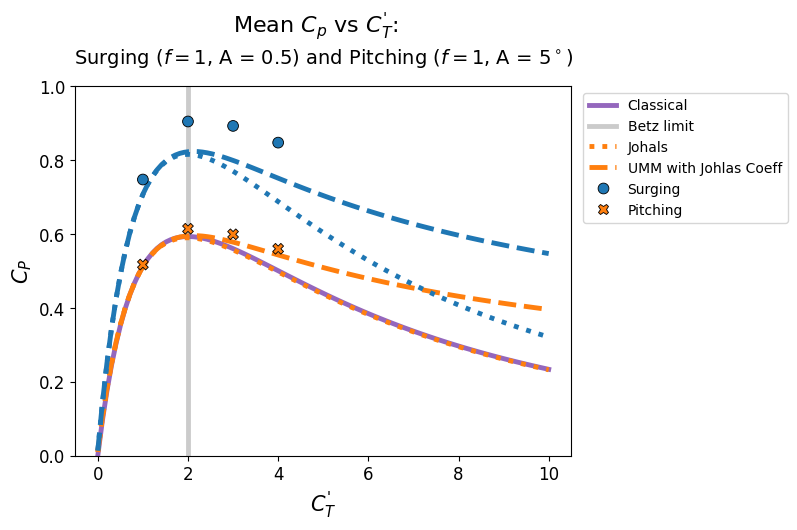

In [113]:
fig, ax = plt.subplots(1, 1)
fig.suptitle("Mean $C_p$ vs $C_T^'$:", size = 16, y = 1.04)
plt.title("Surging ($f = 1$, A = $0.5$) and Pitching ($f = 1$, A = $5^\circ$)", size = 14, y = 1.04)
ax.set_xlabel('$C_T^\'$', size = 15)
ax.set_ylabel('$C_P$', size = 15)
ax.tick_params(axis='both', which='major', labelsize=12)
linewidth = 3.5
ax.set_ylim(0, 1)

# plot classical and betz
ctp_list = np.linspace(0, 10, num = 100)
classical_cp = [a_to_Cp(analytical_a(ctp)) for ctp in ctp_list]
# 1
sns.lineplot(x = ctp_list, y = classical_cp, color = 'tab:purple', label = "Classical", linewidth = linewidth)
fix_legend(ax)
plt.savefig("/Users/sky/Downloads/classical.png", dpi=300, bbox_inches = "tight")
# 2
ax.axvline(2, label = "Betz limit", color = 'tab:grey', linewidth = linewidth, alpha = 0.4)
fix_legend(ax)
plt.savefig("/Users/sky/Downloads/betz.png", dpi=300, bbox_inches = "tight")

# pre-betz
# ctp_pre_betz = ctp_list[0:21]
# classical_pre_betz = classical_cp[0:21]
# johlas_pitch_classical_pre_betz = johlas_pitch_classical[0:21]
# johlas_surge_pre_betz = johlas_surge_classical[0:21]
# les_pre_betz = max_motion_df[max_motion_df["CT_prime"] <= 2]
# 3
# sns.lineplot(x = ctp_pre_betz, y = johlas_pitch_classical_pre_betz, color = 'tab:orange', label = "Johlas pitch", linewidth = linewidth)
# fix_legend(ax)
# plt.savefig("/Users/sky/Downloads/johlas_pitch_classical_pre_betz.png", dpi=300, bbox_inches = "tight")
# 4
# sns.lineplot(x = ctp_pre_betz, y = johlas_surge_pre_betz, color = 'tab:blue', label = "Johlas surge", linewidth = linewidth)
# fix_legend(ax)
# plt.savefig("/Users/sky/Downloads/johlas_surge_pre_betz.png", dpi=300, bbox_inches = "tight")
#5
palette =['tab:blue', 'tab:orange']
# sns.scatterplot(data = les_pre_betz, x = "CT_prime", y = "mean_Cp", hue = "Movement", style = "Movement", palette = palette, edgecolor = 'k', zorder = 5,  s=60)
# fix_legend(ax)
# plt.savefig("/Users/sky/Downloads/data_pre_betz.png", dpi=300, bbox_inches = "tight")

# 6
sns.lineplot(x = ctp_list, y = johlas_pitch_classical, color = 'tab:orange', linestyle = "dotted", linewidth = linewidth, label = "Johals")
sns.lineplot(x = ctp_list, y = johlas_pitch_umm, color = 'tab:orange', linewidth = linewidth, linestyle = "dashed", label = "UMM with Johlas Coeff")
# fix_legend(ax)
# plt.savefig("/Users/sky/Downloads/johlas_pitch_post_betz.png", dpi=300, bbox_inches = "tight")
# 7
sns.lineplot(x = ctp_list, y = johlas_surge_classical, color = 'tab:blue', linestyle = "dotted", linewidth = linewidth)
sns.lineplot(x = ctp_list, y = johlas_surge_umm, color = 'tab:blue', linewidth = linewidth, linestyle = "dashed")
# fix_legend(ax)
# plt.savefig("/Users/sky/Downloads/johlas_surge_post_betz.png", dpi=300, bbox_inches = "tight")
# 8
sns.scatterplot(data = max_motion_df, x = "CT_prime", y = "mean_Cp", hue = "Movement", style = "Movement", palette = palette, edgecolor = 'k', zorder = 5,  s=60)
# fix_legend(ax)
# plt.savefig("/Users/sky/Downloads/data_post_betz.png", dpi=300, bbox_inches = "tight")

leg = ax.legend()
bb = leg.get_bbox_to_anchor().transformed(ax.transAxes.inverted())
xOffset = 0.45
bb.x0 += xOffset
bb.x1 += xOffset
leg = leg.set_bbox_to_anchor(bb, transform = ax.transAxes)

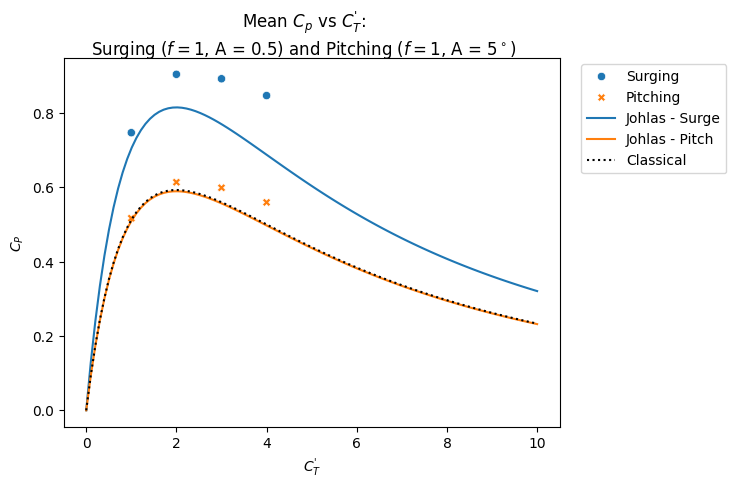

In [114]:
fig, ax = plt.subplots(1, 1)
fig.suptitle("Mean $C_p$ vs $C_T^'$:\nSurging ($f = 1$, A = $0.5$) and Pitching ($f = 1$, A = $5^\circ$)")
ax.set_xlabel('$C_T^\'$')
ax.set_ylabel('$C_P$')
palette =['tab:blue', 'tab:orange']
sns.scatterplot(data = max_motion_df, x = "CT_prime", y = "mean_Cp", hue = "Movement", style = "Movement", palette = palette)

ctp_list = np.linspace(0, 10, num = 100)
classical_cp = [a_to_Cp(analytical_a(ctp)) for ctp in ctp_list]
johlas_surge_classical = [johlas(cp, 0.5, 0.0) for cp in classical_cp]
johlas_pitch_classical = [johlas(cp, 0.0, 5.0) for cp in classical_cp]
sns.lineplot(x = ctp_list, y = johlas_surge_classical, color = palette[0], label = "Johlas - Surge")
sns.lineplot(x = ctp_list, y = johlas_pitch_classical, color = palette[1], label = "Johlas - Pitch")
sns.lineplot(x = ctp_list, y = classical_cp, color = 'k', linestyle=':', label = "Classical")

leg = ax.legend()
bb = leg.get_bbox_to_anchor().transformed(ax.transAxes.inverted())
xOffset = 0.35
bb.x0 += xOffset
bb.x1 += xOffset
leg = leg.set_bbox_to_anchor(bb, transform = ax.transAxes)

In [115]:
ct1_df = df[(df["CT_prime"] == 1) & (df["surge_freq"] != 0)]
ct1_df["amp"] = ct1_df.apply((lambda row: np.maximum(row.surge_amplitude, row.pitch_amplitude)), axis = 1)

classical_cp = a_to_Cp(analytical_a(1.0))
ct1_df["normalized_mean_cp"] = ct1_df.apply((lambda row: row.mean_Cp / classical_cp), axis = 1)
ct1_df["percent_diff_classical"] = ct1_df.apply((lambda row: 100 * (row.mean_Cp - classical_cp) / classical_cp), axis = 1)

surge_df = ct1_df[ct1_df["Movement"] == "Surging"]
pitch_df = ct1_df[ct1_df["Movement"] == "Pitching"]

/var/folders/dt/wzb0_01j5yz8q2y9bz5sfjm00000gn/T/ipykernel_11942/2257410152.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ct1_df["amp"] = ct1_df.apply((lambda row: np.maximum(row.surge_amplitude, row.pitch_amplitude)), axis = 1)
/var/folders/dt/wzb0_01j5yz8q2y9bz5sfjm00000gn/T/ipykernel_11942/2257410152.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ct1_df["normalized_mean_cp"] = ct1_df.apply((lambda row: row.mean_Cp / classical_cp), axis = 1)
/var/folders/dt/wzb0_01j5yz8q2y9bz5sfjm00000gn/T/ipyk

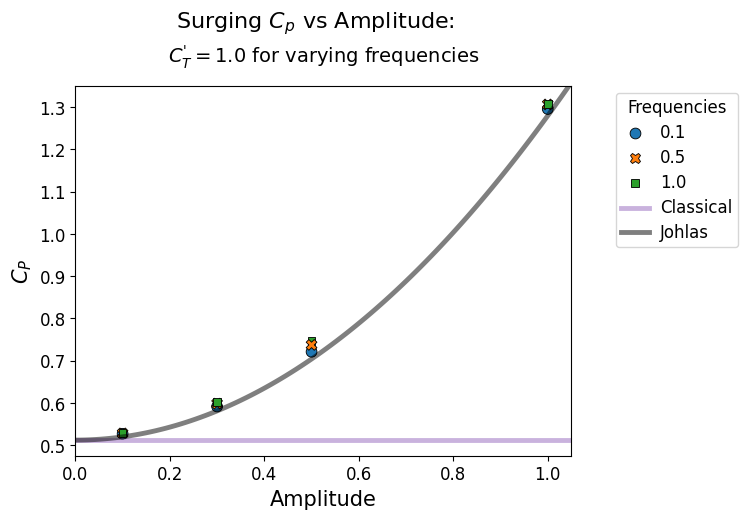

In [116]:
fig, ax = plt.subplots(1, 1)
fig.suptitle("Surging $C_p$ vs Amplitude:", size = 16, y = 1.04)
plt.title("$C_T^\' = 1.0$ for varying frequencies", size = 14, y = 1.04)
ax.set_xlabel('Amplitude', size = 15)
ax.set_ylabel('$C_P$', size = 15)
ax.set_xlim(0, 1.05)
ax.set_ylim(0.475, 1.35)
ax.tick_params(axis='both', which='major', labelsize=12)
linewidth = 3.5

palette =['tab:blue', 'tab:orange', 'tab:green']

amp = np.linspace(0.0, 1.05, num = 100)
johlas_surge_classical = [johlas(classical_cp, a, 0.0) for a in amp]

# ax.axhline(y = classical_cp, color = 'tab:purple', label = "Classical", linewidth = linewidth)
# fix_legend(ax)
# plt.savefig("/Users/sky/Downloads/classical.png", dpi=300, bbox_inches = "tight")

# sns.lineplot(x = amp, y = johlas_surge_classical, color = 'k', label = "Johlas", linewidth = linewidth, zorder = 3)
# fix_legend(ax)
# plt.savefig("/Users/sky/Downloads/johlas.png", dpi=300, bbox_inches = "tight")

# sns.scatterplot(data = surge_df[surge_df["amp"] < 0.3], x = "amp", y = "mean_Cp", hue = "surge_freq", style = "surge_freq", palette = palette, edgecolor = 'k',  s=60)
# fix_legend(ax)
# plt.savefig("/Users/sky/Downloads/first_apm.png", dpi=300, bbox_inches = "tight")

# sns.scatterplot(data = surge_df[surge_df["amp"] < 0.5], x = "amp", y = "mean_Cp", hue = "surge_freq", style = "surge_freq", palette = palette, edgecolor = 'k',  s=60)
# fix_legend(ax)
# plt.savefig("/Users/sky/Downloads/second_apm.png", dpi=300, bbox_inches = "tight")

sns.scatterplot(data = surge_df, x = "amp", y = "mean_Cp", hue = "surge_freq", style = "surge_freq", palette = palette, edgecolor = 'k',  s=60)
fix_legend(ax)

amp = np.linspace(0.0, 1.05, num = 100)
johlas_surge_classical = [johlas(classical_cp, a, 0.0) for a in amp]

ax.axhline(y = classical_cp, color = 'tab:purple', label = "Classical", linewidth = linewidth, alpha = 0.5)
fix_legend(ax)
plt.savefig("/Users/sky/Downloads/classical.png", dpi=300, bbox_inches = "tight")

sns.lineplot(x = amp, y = johlas_surge_classical, color = 'k', label = "Johlas", linewidth = linewidth, zorder = 3, alpha = 0.5)
fix_legend(ax, title = "Frequencies")
plt.savefig("/Users/sky/Downloads/johlas.png", dpi=300, bbox_inches = "tight")

plt.savefig("/Users/sky/Downloads/third_apm.png", dpi=300, bbox_inches = "tight")

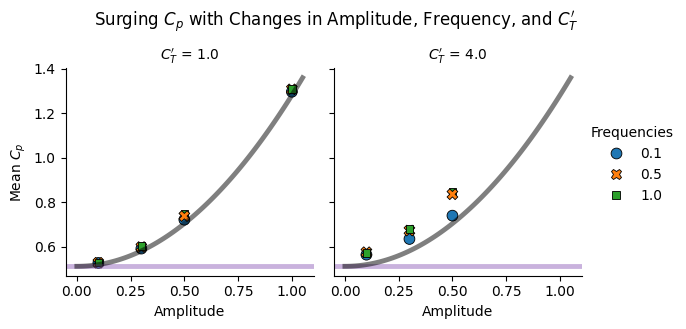

In [117]:
surge_df_all_ct = df[(df["CT_prime"] == 1) | (df["CT_prime"] == 4)]
surge_df_all_ct = surge_df_all_ct[(surge_df_all_ct["surge_freq"] != 0)]
surge_df_all_ct["amp"] = surge_df_all_ct.apply((lambda row: np.maximum(row.surge_amplitude, row.pitch_amplitude)), axis = 1)
surge_df = surge_df_all_ct[surge_df_all_ct["Movement"] == "Surging"]
g = sns.FacetGrid(surge_df, col = "CT_prime", sharey = True)
g.map_dataframe(sns.scatterplot, x = "amp", y = "mean_Cp", hue = "surge_freq", style = "surge_freq", palette = palette, edgecolor = 'k',  s=60)
g.set_ylabels("Mean $C_p$")
g.set_xlabels("Amplitude")

small_ct_ax, large_ct_ax = g.axes.flat
small_ct_ax.axhline(y = classical_cp, color = 'tab:purple', linewidth = linewidth, alpha = 0.5)
large_ct_ax.axhline(y = classical_cp, color = 'tab:purple', linewidth = linewidth, alpha = 0.5)

sns.lineplot(ax = small_ct_ax, x = amp, y = johlas_surge_classical, color = 'k', linewidth = linewidth, zorder = 3, alpha = 0.5, legend = False)
sns.lineplot(ax = large_ct_ax, x = amp, y = johlas_surge_classical, color = 'k', linewidth = linewidth, zorder = 3, alpha = 0.5, legend = False)
g.add_legend(title = "Frequencies")
g.set_titles("$C_T'$ = {col_name}")
plt.suptitle("Surging $C_p$ with Changes in Amplitude, Frequency, and $C_T'$", y = 1.08)

plt.savefig("/Users/sky/Downloads/surge_explore.png", dpi=300, bbox_inches = "tight")

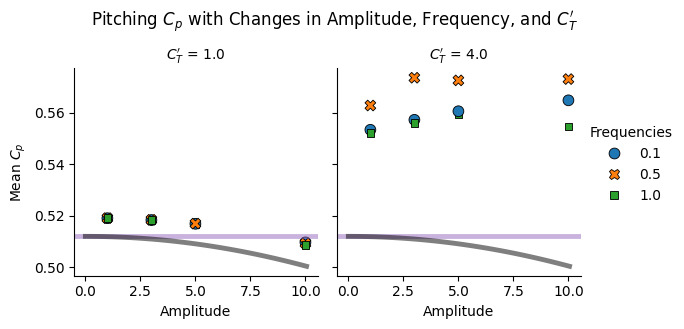

In [118]:
pitch_df = surge_df_all_ct[surge_df_all_ct["Movement"] == "Pitching"]
g = sns.FacetGrid(pitch_df, col = "CT_prime", sharey = True)
g.map_dataframe(sns.scatterplot, x = "amp", y = "mean_Cp", hue = "surge_freq", style = "surge_freq", palette = palette, edgecolor = 'k',  s=60)
g.set_ylabels("Mean $C_p$")
g.set_xlabels("Amplitude")


amp = np.linspace(0.0, 10.05, num = 100)
johlas_pitch_classical = [johlas(classical_cp, 0.0, a) for a in amp]
small_ct_ax, large_ct_ax = g.axes.flat
small_ct_ax.axhline(y = classical_cp, color = 'tab:purple', linewidth = linewidth, alpha = 0.5)
large_ct_ax.axhline(y = classical_cp, color = 'tab:purple', linewidth = linewidth, alpha = 0.5)

sns.lineplot(ax = small_ct_ax, x = amp, y = johlas_pitch_classical, color = 'k', linewidth = linewidth, zorder = 3, alpha = 0.5, legend = False)
sns.lineplot(ax = large_ct_ax, x = amp, y = johlas_pitch_classical, color = 'k', linewidth = linewidth, zorder = 3, alpha = 0.5, legend = False)

g.add_legend(title = "Frequencies")
g.set_titles("$C_T'$ = {col_name}")
plt.suptitle("Pitching $C_p$ with Changes in Amplitude, Frequency, and $C_T'$", y = 1.08)
plt.savefig("/Users/sky/Downloads/pitch_explore.png", dpi=300, bbox_inches = "tight")

ValueError: Could not interpret value `percent_diff_classical` for `y`. An entry with this name does not appear in `data`.

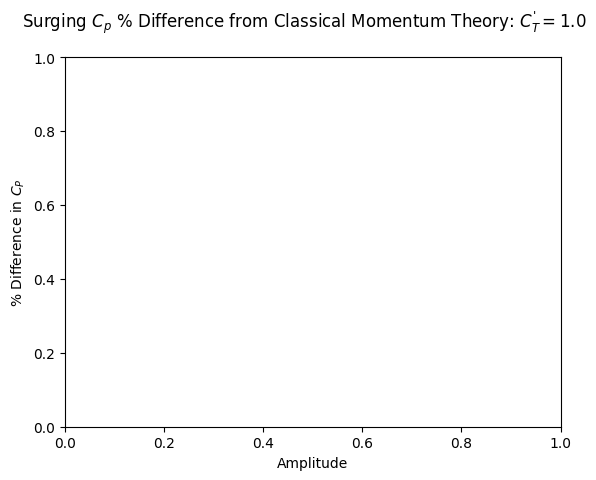

In [119]:
fig, ax = plt.subplots(1, 1)
fig.suptitle("Surging $C_p$ % Difference from Classical Momentum Theory: $C_T^\' = 1.0$")
ax.set_xlabel('Amplitude')
ax.set_ylabel('% Difference in $C_P$')

palette =['tab:blue', 'tab:orange', 'tab:green']

sns.scatterplot(data = surge_df, x = "amp", y = "percent_diff_classical", hue = "surge_freq", style = "surge_freq", palette = palette)

amp = np.linspace(0, 0.55, num = 100)
johlas_surge_classical = [(100 * (johlas(classical_cp, a, 0.0) - classical_cp) / classical_cp) for a in amp]
sns.lineplot(x = amp, y = johlas_surge_classical, color = 'k', label = "Johlas")
ax.axhline(y = 0, color = 'r', linestyle=':', label = "Classical")

leg = ax.legend(title = "Frequency")
bb = leg.get_bbox_to_anchor().transformed(ax.transAxes.inverted())
xOffset = 0.25
bb.x0 += xOffset
bb.x1 += xOffset
leg = leg.set_bbox_to_anchor(bb, transform = ax.transAxes)

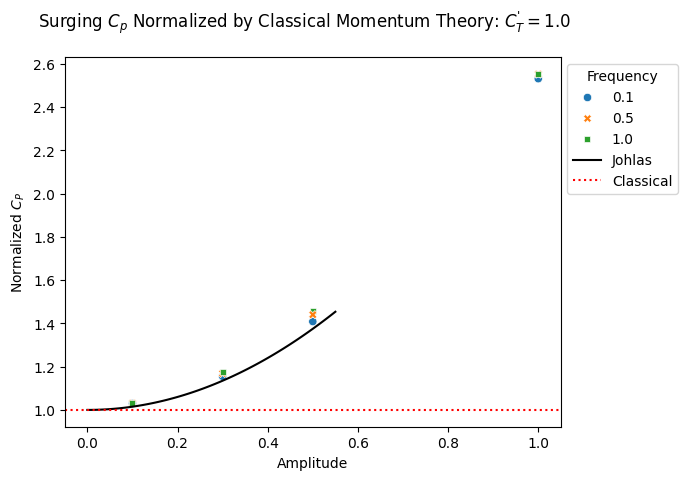

In [ ]:
fig, ax = plt.subplots(1, 1)
fig.suptitle("Surging $C_p$ Normalized by Classical Momentum Theory: $C_T^\' = 1.0$")
ax.set_xlabel('Amplitude')
ax.set_ylabel('Normalized $C_P$')

palette =['tab:blue', 'tab:orange', 'tab:green']

sns.scatterplot(data = surge_df, x = "amp", y = "normalized_mean_cp", hue = "surge_freq", style = "surge_freq", palette = palette)

amp = np.linspace(0, 0.55, num = 100)
johlas_surge_classical = [(johlas(classical_cp, a, 0.0) / classical_cp) for a in amp]
sns.lineplot(x = amp, y = johlas_surge_classical, color = 'k', label = "Johlas")
ax.axhline(y = 1, color = 'r', linestyle=':', label = "Classical")

leg = ax.legend(title = "Frequency")
bb = leg.get_bbox_to_anchor().transformed(ax.transAxes.inverted())
xOffset = 0.25
bb.x0 += xOffset
bb.x1 += xOffset
leg = leg.set_bbox_to_anchor(bb, transform = ax.transAxes)

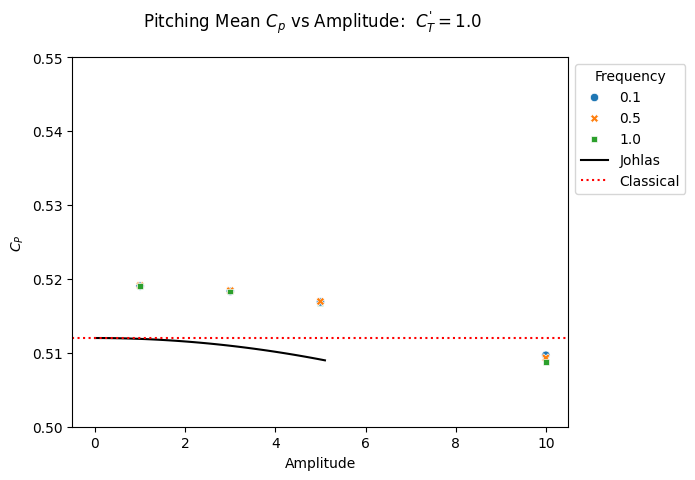

In [ ]:
fig, ax = plt.subplots(1, 1)
fig.suptitle("Pitching Mean $C_p$ vs Amplitude:  $C_T^\' = 1.0$")
ax.set_xlabel('Amplitude')
ax.set_ylabel('$C_P$')
ax.set_ylim(0.5, 0.55)

palette =['tab:blue', 'tab:orange', 'tab:green']
sns.scatterplot(data = pitch_df, x = "amp", y = "mean_Cp", hue = "surge_freq", style = "surge_freq", palette = palette)

amp = np.linspace(0, 5.1, num = 100)
johlas_pitch_classical = [johlas(classical_cp, 0.0, a) for a in amp]
sns.lineplot(x = amp, y = johlas_pitch_classical, color = 'k', label = "Johlas")
ax.axhline(y = classical_cp, color = 'r', linestyle=':', label = "Classical")

leg = ax.legend(title = "Frequency")
bb = leg.get_bbox_to_anchor().transformed(ax.transAxes.inverted())
xOffset = 0.25
bb.x0 += xOffset
bb.x1 += xOffset
leg = leg.set_bbox_to_anchor(bb, transform = ax.transAxes)

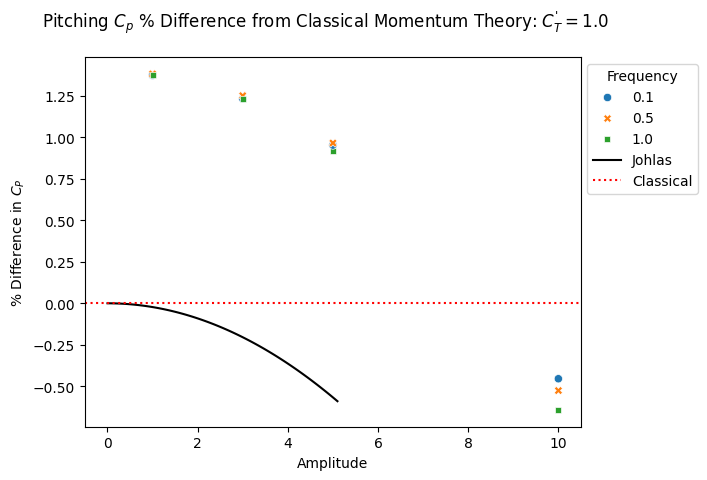

In [ ]:
fig, ax = plt.subplots(1, 1)
fig.suptitle("Pitching $C_p$ % Difference from Classical Momentum Theory: $C_T^\' = 1.0$")
ax.set_xlabel('Amplitude')
ax.set_ylabel('% Difference in $C_P$')

palette =['tab:blue', 'tab:orange', 'tab:green']
sns.scatterplot(data = pitch_df, x = "amp", y = "percent_diff_classical", hue = "surge_freq", style = "surge_freq", palette = palette)

amp = np.linspace(0, 5.1, num = 100)
johlas_pitch_classical = [100 * (johlas(classical_cp, 0.0, a) - classical_cp) / classical_cp for a in amp]
sns.lineplot(x = amp, y = johlas_pitch_classical, color = 'k', label = "Johlas")
ax.axhline(y = 0, color = 'r', linestyle=':', label = "Classical")

leg = ax.legend(title = "Frequency")
bb = leg.get_bbox_to_anchor().transformed(ax.transAxes.inverted())
xOffset = 0.25
bb.x0 += xOffset
bb.x1 += xOffset
leg = leg.set_bbox_to_anchor(bb, transform = ax.transAxes)